In [1]:
import os
import pandas as pd
import glob
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from sksurv.ensemble import RandomSurvivalForest
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
from scipy.stats import chi2_contingency
from sklearn.calibration import calibration_curve
from matplotlib.font_manager import FontProperties
from sksurv.metrics import concordance_index_censored
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.metrics import integrated_brier_score
from sksurv.datasets import load_flchain
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sksurv.util import Surv
from sklearn.metrics import roc_curve
plt.rcParams['font.sans-serif']=['Times New Roman']
pd.set_option('display.max_columns', None)

In [30]:
def combine_xlsx(path, merged_path):    
    files = [f for f in os.listdir(path) if f.endswith('.xlsx')]
    print(files)
    merged_data = pd.DataFrame()
    for file in files:
        file_path = os.path.join(path, file)
        df = pd.read_excel(file_path)
        merged_data = pd.concat([merged_data, df], ignore_index=True)
    merged_data.to_excel(merged_path, index=False)

In [42]:
combine_xlsx('./NHANES数据库1999-2020年/饮酒状况','./NHANES数据库1999-2020年/饮酒状况.xlsx')

['2011-2012年饮酒状况.xlsx', '2019-2020年饮酒状况.xlsx', '2017-2018年饮酒状况.xlsx', '2013-2014年饮酒状况.xlsx', '2007-2008年饮酒状况.xlsx', '2009-2010年饮酒状况.xlsx', '2015-2016年饮酒状况.xlsx']


In [43]:
files = [f for f in os.listdir('./NHANES数据库1999-2020年') if f.endswith('.xlsx')]

In [57]:
file_list = glob.glob('./NHANES数据库1999-2020年/*.xlsx')
print(file_list)
# 读取第一个文件，设置为基础数据框
df = pd.read_excel(file_list[0])
for file in file_list[1:]:
    # 读取每个文件
    df_temp = pd.read_excel(file)
    # 根据ID列合并数据
    df = pd.merge(df, df_temp, on='SEQN', how='outer')

['./NHANES数据库1999-2020年/血压和胆固醇.xlsx', './NHANES数据库1999-2020年/吸烟状况.xlsx', './NHANES数据库1999-2020年/血浆空腹糖浆.xlsx', './NHANES数据库1999-2020年/糖尿病.xlsx', './NHANES数据库1999-2020年/BMI.xlsx', './NHANES数据库1999-2020年/体力活动.xlsx', './NHANES数据库1999-2020年/血压测量.xlsx', './NHANES数据库1999-2020年/人口统计.xlsx', './NHANES数据库1999-2020年/心血管疾病.xlsx', './NHANES数据库1999-2020年/Q-9抑郁症.xlsx', './NHANES数据库1999-2020年/总胆固醇.xlsx', './NHANES数据库1999-2020年/饮酒状况.xlsx']


In [64]:
dead = pd.read_excel('./NHANES数据库1999-2020年/死亡/NHANES死亡数据.xlsx')

In [65]:
df = pd.merge(df, dead, on='SEQN', how='outer')

In [84]:
df.to_excel('./总数据.xlsx', index=False)

In [5]:
df = pd.read_excel('./总数据.xlsx')
df

,SEQN,BPQ020（曾经告诉过你有高血压）,BPQ040A（服用高血压处方）,BPQ050A（现在正在服用治疗HBP的处方药）,BPQ080（曾经被告知的血液胆固醇水平很高）,BPQ090D（被告知服用胆固醇处方药）,BPQ100D（现在正在服用处方药）,SMQ020（一生中至少抽过 100 支烟？）,SMQ040（现在抽烟吗？）,SMQ050Q（戒烟多久了？）,LBXGLU（空腹血糖mg/dL),DIQ010（医生告诉你有糖尿病）,DIQ050（现在服用胰岛素）,DIQ070（服用糖尿病药来降低血糖）,BMXBMI（BMI）,PAD615（高强度工作分钟）,PAD630（中等强度工作分钟）,PAD645（步行/自行车分钟）,PAD660（剧烈娱乐活动分钟）,PAD675（中等娱乐活动分钟）,BPXSY1（收缩压：血压第 1 次）,BPXDI1（舒张压：血压第 1 次）,BPXSY2（收缩压：血压第 2 次）,BPXDI2（舒张压：血压第 2次）,BPXSY3（收缩压：血压第 3次）,BPXDI3（舒张压：血压第 3 次）,RIAGENDR（性别）,RIDAGEYR（年龄）,RIDRETH1（种族）,MCQ160B（充血性心力衰竭）,MCQ160C（冠心病）,MCQ160D（心绞痛）,MCQ160F（中风）,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100,LBXTC,LBDTCSI,LBDTCSI(总胆固醇mmol/L）,ALQ101（每 1 年至少喝过 12 杯酒）,MORTSTAT(最终死亡状况),PERMTH_INT（月份）,class
0,51624,2,1,1,2,2,1,1,3,1,101,2,2,2,32.22,120,120,30,60,60,114,88,114,88,112,82,1,34,3,2,2,2,2,2,1,2,1,1,1,1,1,0,1,187,4.84,3.49,1,0,111,moderate
1,51624,2,1,1,2,2,1,1,3,1,101,2,2,2,32.22,120,120,30,60,60,114,88,114,88,112,82,1,34,3,2,2,2,2,2,1,2,1,1,1,1,1,0,1,187,4.84,3.49,1,0,322,moderate
2,51626,2,1,1,2,2,1,2,3,17,101,2,2,2,22.00,120,120,10,60,20,112,62,114,60,104,58,1,16,4,2,2,2,2,0,0,0,0,0,0,0,0,0,0,187,4.84,4.97,1,0,85,none
3,51626,2,1,1,2,2,1,2,3,17,101,2,2,2,22.00,120,120,10,60,20,112,62,114,60,104,58,1,16,4,2,2,2,2,0,0,0,0,0,0,0,0,0,0,187,4.84,4.97,1,0,85,none
4,51628,1,1,1,1,1,2,1,1,17,101,1,2,1,42.39,120,120,30,60,60,154,70,150,68,150,68,2,60,4,2,2,2,2,3,3,2,3,2,2,2,3,0,1,187,4.84,5.22,2,0,133,moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54818,51621,2,1,1,2,2,1,2,3,17,101,2,2,2,17.72,120,120,60,60,60,122,50,120,50,114,44,1,17,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,187,4.84,3.31,1,0,85,none
54819,51622,2,1,1,2,2,1,2,3,17,101,2,2,2,31.53,120,120,30,60,60,148,84,144,86,146,86,2,60,4,2,2,2,2,0,0,0,1,0,0,1,0,0,0,187,4.84,5.38,1,0,142,none
54820,51622,2,1,1,2,2,1,2,3,17,101,2,2,2,31.53,120,120,30,60,60,148,84,144,86,146,86,2,60,4,2,2,2,2,0,0,0,1,0,0,1,0,0,0,187,4.84,5.38,1,1,191,none
54821,51623,2,1,1,1,1,1,1,1,17,121,2,2,2,32.27,120,120,30,60,60,112,66,116,66,120,68,1,72,3,2,1,1,2,0,0,1,3,0,0,0,0,0,9,187,4.84,2.95,1,1,30,moderate


In [86]:
missing_percent = df.isnull().sum() / len(df) * 100
missing_percent

SEQN                        0.0
BPQ020（曾经告诉过你有高血压）          0.0
BPQ040A（服用高血压处方）            0.0
BPQ050A（现在正在服用治疗HBP的处方药）    0.0
BPQ080（曾经被告知的血液胆固醇水平很高）     0.0
BPQ090D（被告知服用胆固醇处方药）        0.0
BPQ100D（现在正在服用处方药）          0.0
SMQ020（一生中至少抽过 100 支烟？）     0.0
SMQ040（现在抽烟吗？）              0.0
SMQ050Q（戒烟多久了？）             0.0
LBXGLU（空腹血糖mg/dL)           0.0
DIQ010（医生告诉你有糖尿病）           0.0
DIQ050（现在服用胰岛素）             0.0
DIQ070（服用糖尿病药来降低血糖）         0.0
BMXBMI（BMI）                 0.0
PAD615（高强度工作分钟）             0.0
PAD630（中等强度工作分钟）            0.0
PAD645（步行/自行车分钟）            0.0
PAD660（剧烈娱乐活动分钟）            0.0
PAD675（中等娱乐活动分钟）            0.0
BPXSY1（收缩压：血压第 1 次）         0.0
BPXDI1（舒张压：血压第 1 次）         0.0
BPXSY2（收缩压：血压第 2 次）         0.0
BPXDI2（舒张压：血压第 2次）          0.0
BPXSY3（收缩压：血压第 3次）          0.0
BPXDI3（舒张压：血压第 3 次）         0.0
RIAGENDR（性别）                0.0
RIDAGEYR（年龄）                0.0
RIDRETH1（种族）                0.0
MCQ160B（充血性心力衰竭）            0.0
MCQ160C（冠心病）                0.0
MCQ160D（

In [92]:
df = df.fillna(df.median())

TypeError: could not convert string to float: 'moderate'

In [6]:
# DPQ10-100
df['class'] = df['DPQ010']+df['DPQ020']+df['DPQ030']+df['DPQ040']+df['DPQ050']+df['DPQ060']+df['DPQ070']+df['DPQ080']+df['DPQ090']+df['DPQ100']
conditions = [
    (df['class'].between(0,4)),
    (df['class'].between(5,9)),
    (df['class'].between(10,100))
]
values = ['none','mild','moderate']
df.loc[conditions[0], 'class'] = values[0]
df.loc[conditions[1], 'class'] = values[1]
df.loc[conditions[2], 'class'] = values[2]

/var/folders/7l/bt2fpgts131d7zyt1f1n2d140000gn/T/ipykernel_14538/2283194364.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'none' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[conditions[0], 'class'] = values[0]


In [7]:
df['class'].value_counts()

class
none        42541
mild         7401
moderate     4881
Name: count, dtype: int64

In [8]:
df

,SEQN,BPQ020（曾经告诉过你有高血压）,BPQ040A（服用高血压处方）,BPQ050A（现在正在服用治疗HBP的处方药）,BPQ080（曾经被告知的血液胆固醇水平很高）,BPQ090D（被告知服用胆固醇处方药）,BPQ100D（现在正在服用处方药）,SMQ020（一生中至少抽过 100 支烟？）,SMQ040（现在抽烟吗？）,SMQ050Q（戒烟多久了？）,LBXGLU（空腹血糖mg/dL),DIQ010（医生告诉你有糖尿病）,DIQ050（现在服用胰岛素）,DIQ070（服用糖尿病药来降低血糖）,BMXBMI（BMI）,PAD615（高强度工作分钟）,PAD630（中等强度工作分钟）,PAD645（步行/自行车分钟）,PAD660（剧烈娱乐活动分钟）,PAD675（中等娱乐活动分钟）,BPXSY1（收缩压：血压第 1 次）,BPXDI1（舒张压：血压第 1 次）,BPXSY2（收缩压：血压第 2 次）,BPXDI2（舒张压：血压第 2次）,BPXSY3（收缩压：血压第 3次）,BPXDI3（舒张压：血压第 3 次）,RIAGENDR（性别）,RIDAGEYR（年龄）,RIDRETH1（种族）,MCQ160B（充血性心力衰竭）,MCQ160C（冠心病）,MCQ160D（心绞痛）,MCQ160F（中风）,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100,LBXTC,LBDTCSI,LBDTCSI(总胆固醇mmol/L）,ALQ101（每 1 年至少喝过 12 杯酒）,MORTSTAT(最终死亡状况),PERMTH_INT（月份）,class
0,51624,2,1,1,2,2,1,1,3,1,101,2,2,2,32.22,120,120,30,60,60,114,88,114,88,112,82,1,34,3,2,2,2,2,2,1,2,1,1,1,1,1,0,1,187,4.84,3.49,1,0,111,moderate
1,51624,2,1,1,2,2,1,1,3,1,101,2,2,2,32.22,120,120,30,60,60,114,88,114,88,112,82,1,34,3,2,2,2,2,2,1,2,1,1,1,1,1,0,1,187,4.84,3.49,1,0,322,moderate
2,51626,2,1,1,2,2,1,2,3,17,101,2,2,2,22.00,120,120,10,60,20,112,62,114,60,104,58,1,16,4,2,2,2,2,0,0,0,0,0,0,0,0,0,0,187,4.84,4.97,1,0,85,none
3,51626,2,1,1,2,2,1,2,3,17,101,2,2,2,22.00,120,120,10,60,20,112,62,114,60,104,58,1,16,4,2,2,2,2,0,0,0,0,0,0,0,0,0,0,187,4.84,4.97,1,0,85,none
4,51628,1,1,1,1,1,2,1,1,17,101,1,2,1,42.39,120,120,30,60,60,154,70,150,68,150,68,2,60,4,2,2,2,2,3,3,2,3,2,2,2,3,0,1,187,4.84,5.22,2,0,133,moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54818,51621,2,1,1,2,2,1,2,3,17,101,2,2,2,17.72,120,120,60,60,60,122,50,120,50,114,44,1,17,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,187,4.84,3.31,1,0,85,none
54819,51622,2,1,1,2,2,1,2,3,17,101,2,2,2,31.53,120,120,30,60,60,148,84,144,86,146,86,2,60,4,2,2,2,2,0,0,0,1,0,0,1,0,0,0,187,4.84,5.38,1,0,142,none
54820,51622,2,1,1,2,2,1,2,3,17,101,2,2,2,31.53,120,120,30,60,60,148,84,144,86,146,86,2,60,4,2,2,2,2,0,0,0,1,0,0,1,0,0,0,187,4.84,5.38,1,1,191,none
54821,51623,2,1,1,1,1,1,1,1,17,121,2,2,2,32.27,120,120,30,60,60,112,66,116,66,120,68,1,72,3,2,1,1,2,0,0,1,3,0,0,0,0,0,9,187,4.84,2.95,1,1,30,moderate


In [9]:
df = df.drop(df.columns[33:43], axis = 1)
df = df.iloc[:, 1:]
df

,BPQ020（曾经告诉过你有高血压）,BPQ040A（服用高血压处方）,BPQ050A（现在正在服用治疗HBP的处方药）,BPQ080（曾经被告知的血液胆固醇水平很高）,BPQ090D（被告知服用胆固醇处方药）,BPQ100D（现在正在服用处方药）,SMQ020（一生中至少抽过 100 支烟？）,SMQ040（现在抽烟吗？）,SMQ050Q（戒烟多久了？）,LBXGLU（空腹血糖mg/dL),DIQ010（医生告诉你有糖尿病）,DIQ050（现在服用胰岛素）,DIQ070（服用糖尿病药来降低血糖）,BMXBMI（BMI）,PAD615（高强度工作分钟）,PAD630（中等强度工作分钟）,PAD645（步行/自行车分钟）,PAD660（剧烈娱乐活动分钟）,PAD675（中等娱乐活动分钟）,BPXSY1（收缩压：血压第 1 次）,BPXDI1（舒张压：血压第 1 次）,BPXSY2（收缩压：血压第 2 次）,BPXDI2（舒张压：血压第 2次）,BPXSY3（收缩压：血压第 3次）,BPXDI3（舒张压：血压第 3 次）,RIAGENDR（性别）,RIDAGEYR（年龄）,RIDRETH1（种族）,MCQ160B（充血性心力衰竭）,MCQ160C（冠心病）,MCQ160D（心绞痛）,MCQ160F（中风）,LBXTC,LBDTCSI,LBDTCSI(总胆固醇mmol/L）,ALQ101（每 1 年至少喝过 12 杯酒）,MORTSTAT(最终死亡状况),PERMTH_INT（月份）,class
0,2,1,1,2,2,1,1,3,1,101,2,2,2,32.22,120,120,30,60,60,114,88,114,88,112,82,1,34,3,2,2,2,2,187,4.84,3.49,1,0,111,moderate
1,2,1,1,2,2,1,1,3,1,101,2,2,2,32.22,120,120,30,60,60,114,88,114,88,112,82,1,34,3,2,2,2,2,187,4.84,3.49,1,0,322,moderate
2,2,1,1,2,2,1,2,3,17,101,2,2,2,22.00,120,120,10,60,20,112,62,114,60,104,58,1,16,4,2,2,2,2,187,4.84,4.97,1,0,85,none
3,2,1,1,2,2,1,2,3,17,101,2,2,2,22.00,120,120,10,60,20,112,62,114,60,104,58,1,16,4,2,2,2,2,187,4.84,4.97,1,0,85,none
4,1,1,1,1,1,2,1,1,17,101,1,2,1,42.39,120,120,30,60,60,154,70,150,68,150,68,2,60,4,2,2,2,2,187,4.84,5.22,2,0,133,moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54818,2,1,1,2,2,1,2,3,17,101,2,2,2,17.72,120,120,60,60,60,122,50,120,50,114,44,1,17,2,2,2,2,2,187,4.84,3.31,1,0,85,none
54819,2,1,1,2,2,1,2,3,17,101,2,2,2,31.53,120,120,30,60,60,148,84,144,86,146,86,2,60,4,2,2,2,2,187,4.84,5.38,1,0,142,none
54820,2,1,1,2,2,1,2,3,17,101,2,2,2,31.53,120,120,30,60,60,148,84,144,86,146,86,2,60,4,2,2,2,2,187,4.84,5.38,1,1,191,none
54821,2,1,1,1,1,1,1,1,17,121,2,2,2,32.27,120,120,30,60,60,112,66,116,66,120,68,1,72,3,2,1,1,2,187,4.84,2.95,1,1,30,moderate


In [10]:
grouped = df.groupby('class')
dfs = {}
for group_name, group_df in grouped:
    dfs[group_name] = group_df.copy()
    dfs[group_name] = dfs[group_name].drop(dfs[group_name].columns[-1], axis=1)
none = dfs['none']
mild = dfs['mild']
mode = dfs['moderate']

# For Model

In [2]:
thresh_group = np.arange(0,0.7,0.01)
def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    tpr_list = []
    fpr_list = []
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    print(tpr_list)  
    print(fpr_list) 
    return net_benefit_model

def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all

def plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all):
    #Plot
    ax.plot(thresh_group, net_benefit_model, color = 'crimson', label = 'Ref model')
    ax.plot(thresh_group, net_benefit_all, color = 'black',label = 'Treat all')
    ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')

    #Fill，显示出模型较于treat all和treat none好的部分
    y2 = np.maximum(net_benefit_all, 0)
    y1 = np.maximum(net_benefit_model, y2)
    ax.fill_between(thresh_group, y1, y2, color = 'crimson', alpha = 0.2)

    #Figure Configuration， 美化一下细节
    ax.set_xlim(0,1)
    ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)#adjustify the y axis limitation
    ax.set_xlabel(
        xlabel = 'Threshold Probability', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.set_ylabel(
        ylabel = 'Net Benefit', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.grid('major')
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend(loc = 'upper right')

    return ax

# 卡方和

In [3]:
def p_and_chi2(surv1,surv2):
    data_new = pd.DataFrame({'a':surv1, 'b':surv2})
    bins = np.linspace(min(data_new['a'].min(), data_new['b'].min()), max(data_new['a'].max(), data_new['b'].max()), 10)
    data_new['a_binned'] = pd.cut(data_new['a'], bins, labels=False, include_lowest=True)
    data_new['b_binned'] = pd.cut(data_new['b'], bins, labels=False, include_lowest=True)
    contingency_table = pd.crosstab(data_new['a_binned'], data_new['b_binned'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

# RSF

In [134]:
def process_data_rsf(df):
    E = df.iloc[:,36]
    T = df.iloc[:,37]
    SurvObj = np.array([(e, t) for e, t in zip(E, T)], dtype=[('E', np.bool_), ('T', np.float64)])
    X_train, X_test, y_train, y_test = train_test_split(df, SurvObj, test_size=0.3, random_state=10)
    X_train = X_train.iloc[:,:-2]
    X_test = X_test.iloc[:,:-2]
    rsf = RandomSurvivalForest(n_estimators=100,random_state=24)
    rsf.fit(X_train, y_train)
    # pred = rsf.predict(X_test)
    pred2 = rsf.predict_survival_function(X_train)
    probility_all = [] 
    for i in range(len(pred2)):
        probility_all.append(pred2[i].y)   
    probility_12 = []
    probility_36 = []
    probility_60 = []
    probility_96 = [] 
    for j in range(len(probility_all)):
        probility_12.append(probility_all[j][11])
        probility_36.append(probility_all[j][35])
        probility_60.append(probility_all[j][59])
        probility_96.append(probility_all[j][95])
    ccc = []
    
    for i in range(len(y_train)):
        if y_train[i][0]==False:
            ccc.append(0)
        if y_train[i][0]==True:
            ccc.append(1)
    ccc = np.array(ccc)
    probility_12_v2 = []
    for i2 in range(len(probility_96)):
        probility_12_v2.append(1-probility_96[i2])
    probility_12_v2 = np.array(probility_12_v2)
    
    net_benefit_model = calculate_net_benefit_model(thresh_group, probility_12_v2, ccc)
    net_benefit_all = calculate_net_benefit_all(thresh_group, ccc)
    
    return net_benefit_model,net_benefit_all, probility_12_v2, rsf

3.606381152817679e-61


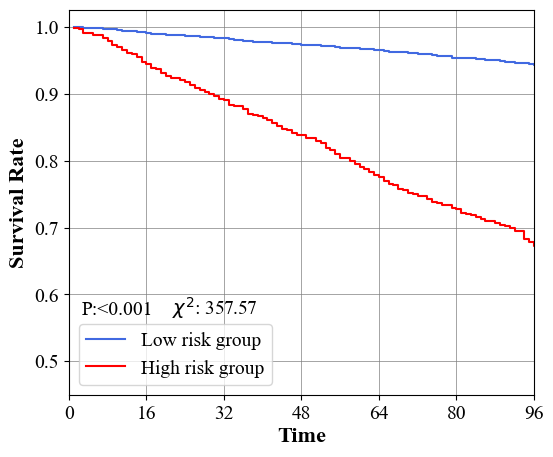

In [23]:
def process_data_rsf_high_low(df):
    E = df.iloc[:,36]
    T = df.iloc[:,37]
    SurvObj = np.array([(e, t) for e, t in zip(E, T)], dtype=[('E', np.bool_), ('T', np.float64)])
    X_train, X_test, y_train, y_test = train_test_split(df, SurvObj, test_size=0.3, random_state=10)
    rsf = RandomSurvivalForest(n_estimators=100,random_state=24)
    X_train = X_train.iloc[:,:-2]
    X_test = X_test.iloc[:,:-2]
    
    rsf.fit(X_train, y_train)
    risk_scores = rsf.predict(X_test)
    cutoff_value = np.percentile(risk_scores, q=90)
    high_risk_group = X_test[risk_scores > cutoff_value]
    low_risk_group = X_test[risk_scores <= cutoff_value]
    surv1 = rsf.predict_survival_function(low_risk_group, return_array=True)
    surv2 = rsf.predict_survival_function(high_risk_group, return_array=True)
    mean_surv1 = np.mean(surv1, axis=0)
    std_surv1 = np.std(surv1, axis=0)

    mean_surv2 = np.mean(surv2, axis=0)
    std_surv2 = np.std(surv2, axis=0)
    
    chi2,p = p_and_chi2(mean_surv1,mean_surv2)
    
    # 获取时间点
    times = rsf.unique_times_
    plt.figure(figsize=(6, 5))
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['font.size'] = 14 
    
    plt.step(times, mean_surv1, where="post", label="Low risk group",color="royalblue")
    plt.step(times, mean_surv2, where="post", label="High risk group",color="red")
    
    print(p)
    plt.text(10, 0.57, f"P:<0.001", ha='center')
    plt.text(30, 0.57, fr"$\chi^2$: {chi2:.2f}", ha='center')
    
    plt.grid(True,color='gray', linestyle='-', linewidth=0.5)
    plt.xlim(0, 96)
    plt.xticks([0, 16, 32, 48,64,80,96])
    plt.gca().set_facecolor('white')
    plt.xlabel('Time', fontsize=16, fontweight='bold')
    plt.ylabel('Survival Rate', fontsize=16, fontweight='bold')
    plt.legend(loc='lower left')
    
    plt.show()
process_data_rsf_high_low(mild)

# COX

In [63]:
def process_data_cox(df):
    train_data, test_data = train_test_split(df, test_size=0.3, random_state=10)
    cox = CoxPHFitter()
    cox.fit(train_data, duration_col='PERMTH_INT（月份）', event_col='MORTSTAT(最终死亡状况)')
    pred2 = cox.predict_survival_function(train_data)
    probility = pred2.values.tolist()
    probility_v2 = probility[60]
    probility_v3 = []
    for i in range(len(probility_v2)):
        probility_v3.append(1-probility_v2[i])
    # print(len(train_data))
    # print(len(test_data))
    # print(len(probility_v3))
        
    net_benefit_model2 = calculate_net_benefit_model(thresh_group, probility_v3, train_data['MORTSTAT(最终死亡状况)'])
    net_benefit_all2 = calculate_net_benefit_all(thresh_group, train_data['MORTSTAT(最终死亡状况)'])
    
    return net_benefit_model2, net_benefit_all2, probility_v3

# Benefit

In [25]:
def show_plot(net_benefit_model,net_benefit_model2, net_benefit_all, net_benefit_all2):
    fig, ax = plt.subplots()

    ax.plot(thresh_group, net_benefit_model, color = 'crimson', label = 'Rsf model')
    ax.plot(thresh_group, net_benefit_model2, color = 'royalblue', label = 'Cox model')
    ax.plot(thresh_group, net_benefit_all, color = 'black',label = 'Treat all')
    ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')

    #Fill，显示出模型较于treat all和treat none好的部分
    y2 = np.maximum(net_benefit_all, 0)
    y1 = np.maximum(net_benefit_model, y2)
    y4 = np.maximum(net_benefit_all2, 0)
    y3 = np.maximum(net_benefit_model2, y2)
    ax.fill_between(thresh_group, y1, y2, color = 'crimson', alpha = 0.2)
    ax.fill_between(thresh_group, y3, y4, color = 'royalblue', alpha = 0.2)

    #Figure Configuration， 美化一下细节
    ax.set_xlim(0,0.7)
    ax.set_ylim(-0.20, net_benefit_model.max() + 0.15)#adjustify the y axis limitation
    ax.set_xlabel(
        xlabel = 'Threshold Probability', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.set_ylabel(
        ylabel = 'Net Benefit', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.grid('major')
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend(loc = 'upper right')
    #ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all)
    fig.savefig('se_train.png', dpi = 300)
    plt.show()

In [56]:
net_benefit_model,net_benefit_all, _,_ = process_data_rsf(mode)
net_benefit_model2, net_benefit_all2, _ = process_data_cox(mode)

[1.0, 0.9613259668508287, 0.9171270718232044, 0.8729281767955801, 0.7900552486187845, 0.7348066298342542, 0.7292817679558011, 0.6906077348066298, 0.6629834254143646, 0.6298342541436464, 0.6187845303867403, 0.5911602209944752, 0.580110497237569, 0.5580110497237569, 0.5193370165745856, 0.4972375690607735, 0.4861878453038674, 0.4585635359116022, 0.44751381215469616, 0.4198895027624309, 0.40331491712707185, 0.3701657458563536, 0.35911602209944754, 0.3259668508287293, 0.3149171270718232, 0.292817679558011, 0.287292817679558, 0.27624309392265195, 0.2541436464088398, 0.23204419889502761, 0.20994475138121546, 0.20441988950276244, 0.18232044198895028, 0.17679558011049723, 0.16574585635359115, 0.16022099447513813, 0.15469613259668508, 0.13812154696132597, 0.12154696132596685, 0.11602209944751381, 0.11049723756906077, 0.09392265193370165, 0.09392265193370165, 0.08839779005524862, 0.0718232044198895, 0.0718232044198895, 0.0718232044198895, 0.06077348066298342, 0.055248618784530384, 0.0552486187845

/Users/luozeyu/mambaforge/envs/sci_survial/lib/python3.11/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


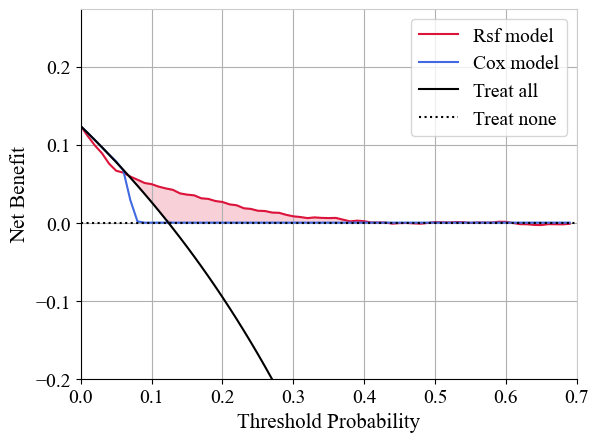

In [57]:
show_plot(net_benefit_model,net_benefit_model2, net_benefit_all, net_benefit_all2)

# Calibration

/Users/luozeyu/mambaforge/envs/sci_survial/lib/python3.11/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


[1.0, 1.0, 0.9979508196721312, 0.9877049180327869, 0.8913934426229508, 0.7745901639344263, 0.6639344262295082, 0.5122950819672131, 0.35655737704918034, 0.2069672131147541, 0.13114754098360656, 0.08811475409836066, 0.04918032786885246, 0.03278688524590164, 0.018442622950819672, 0.010245901639344262, 0.00819672131147541, 0.0020491803278688526, 0.0020491803278688526, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.9993606138107417, 0.9972293265132139, 0.973998294970162, 0.6600596760443308, 0.3702046035805627, 0.21526001705029837, 0.12468030690537084, 0.06905370843989769, 0.0407075873827792, 0.020247229326513214, 0.011082693947144074, 0.006606990622335891, 0.0034100596760443308, 0.002131287297527707, 0.0012787723785166241, 0.0006393861892583121, 0.00021312872975277067, 0.0002131

/var/folders/7l/bt2fpgts131d7zyt1f1n2d140000gn/T/ipykernel_14538/4087051366.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap(cmap)(float(i) / len(probas_list))
/var/folders/7l/bt2fpgts131d7zyt1f1n2d140000gn/T/ipykernel_14538/4087051366.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap(cmap)(float(j) / len(probas_list2))


<Figure size 2560x1920 with 0 Axes>

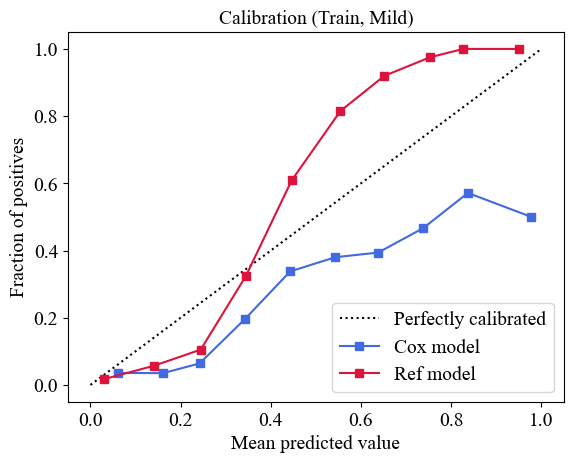

<Figure size 2560x1920 with 0 Axes>

In [70]:
train_data, test_data = train_test_split(mild, test_size=0.3, random_state=10)
y_true = train_data['MORTSTAT(最终死亡状况)']
y_true = np.asarray(y_true)
  
# if not isinstance(probas_list, list):
#     raise ValueError('`probas_list` does not contain a list.')
classes = np.unique(y_true)
if len(classes) > 2:
    raise ValueError('plot_calibration_curve only '
                        'works for binary classification')
_, _, probas_list = process_data_cox(mild) 
_, _, probas_list2,_ = process_data_rsf(mild) 
probas_list = [probas_list]
probas_list2 = [probas_list2]

clf_names = ['Cox model']
clf_names2 = ['Ref model']
if clf_names is None:
    clf_names = ['Classifier {}'.format(x+1)
                    for x in range(len(probas_list))]

if len(clf_names) != len(probas_list):
    raise ValueError('Length {} of `clf_names` does not match length {} of'
                        ' `probas_list`'.format(len(clf_names),
                                                len(probas_list)))
if clf_names2 is None:
    clf_names2 = ['Classifier {}'.format(x+1)
                    for x in range(len(probas_list))]

if len(clf_names2) != len(probas_list):
    raise ValueError('Length {} of `clf_names` does not match length {} of'
                        ' `probas_list`'.format(len(clf_names2),
                                                len(probas_list)))
ax=None
figsize=None
n_bins=10
cmap='nipy_spectral'
title_fontsize="large"
text_fontsize="medium"

if ax is None:
    fig, ax = plt.subplots(1, 1, figsize=figsize)

ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for i, probas in enumerate(probas_list):
    probas = np.asarray(probas)
    if probas.ndim > 2:
        raise ValueError('Index {} in probas_list has invalid '
                            'shape {}'.format(i, probas.shape))
    if probas.ndim == 2:
        probas = probas[:, 1]

    if probas.shape != y_true.shape:
        raise ValueError('Index {} in probas_list has invalid '
                            'shape {}'.format(i, probas.shape))

    probas = (probas - probas.min()) / (probas.max() - probas.min())

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_true, probas, n_bins=n_bins)

    color = plt.cm.get_cmap(cmap)(float(i) / len(probas_list))

    ax.plot(mean_predicted_value, fraction_of_positives, 's-',
            label=clf_names[i], color='royalblue')
    font_properties = FontProperties(family='Times New Roman')
    ax.legend(prop=font_properties)
    
for j, probas2 in enumerate(probas_list2):
    probas2 = np.asarray(probas2)
    if probas2.ndim > 2:
        raise ValueError('Index {} in probas_list has invalid '
                            'shape {}'.format(j, probas2.shape))
    if probas2.ndim == 2:
        probas2 = probas2[:, 1]

    if probas2.shape != y_true.shape:
        raise ValueError('Index {} in probas_list has invalid '
                            'shape {}'.format(j, probas2.shape))

    probas2 = (probas2 - probas2.min()) / (probas2.max() - probas2.min())

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_true, probas2, n_bins=n_bins)

    color = plt.cm.get_cmap(cmap)(float(j) / len(probas_list2))

    ax.plot(mean_predicted_value, fraction_of_positives, 's-',
            label=clf_names2[j], color='crimson')
    font_properties = FontProperties(family='Times New Roman')
    ax.legend(prop=font_properties)


title='Calibration (Train, Mild)'
ax.set_title(title, fontsize=text_fontsize,fontdict= {'family': 'Times New Roman'})

ax.set_xlabel('Mean predicted value', fontsize=text_fontsize,fontdict= {'family': 'Times New Roman'})
ax.set_ylabel('Fraction of positives', fontsize=text_fontsize,fontdict= {'family': 'Times New Roman'})

ax.set_ylim([-0.05, 1.05])
ax.legend(loc='lower right')
plt.figure(dpi=400)

# Relative importance

In [72]:
df_for_importance = df.drop(df.columns[-1], axis=1)
_,_, _,model = process_data_rsf(df_for_importance)

[0.9994308480364257, 0.9701195219123506, 0.9285714285714286, 0.9006829823562891, 0.8824701195219123, 0.8625498007968128, 0.8437677859988617, 0.8255549231644849, 0.815310187820148, 0.8067729083665338, 0.8013659647125783, 0.7928286852589641, 0.7857142857142857, 0.7803073420603301, 0.7720546385885031, 0.7632327831531018, 0.755264655663062, 0.7487194080819579, 0.7418895845190666, 0.7356289129197495, 0.7299373932840069, 0.7199772339214571, 0.707455890722823, 0.6955036994877632, 0.6838360842344906, 0.6690381331815595, 0.6539556061468412, 0.636881047239613, 0.6226522481502561, 0.6044393853158794, 0.5899260102447353, 0.5742743312464428, 0.5620375640295959, 0.5500853727945362, 0.5347182697780307, 0.5173591348890154, 0.5025611838360843, 0.4886169607285145, 0.4732498577120091, 0.4553215708594195, 0.4388161639157655, 0.42145702902675014, 0.4055207740466705, 0.3912919749573136, 0.3730791121229368, 0.3537279453614115, 0.3409220261809903, 0.32527034718269776, 0.31274900398406374, 0.30051223676721683,

In [73]:
from sklearn.inspection import permutation_importance

def relative_importance(df,model):
    E = df.iloc[:,14]
    T = df.iloc[:,15]
    SurvObj = np.array([(e, t) for e, t in zip(E, T)], dtype=[('E', np.bool_), ('T', np.float64)])
    X_train, X_test, y_train, y_test = train_test_split(df, SurvObj, test_size=0.3, random_state=10)
    X_train = X_train.iloc[:,:-2]
    X_test = X_test.iloc[:,:-2]
    result = permutation_importance(model, X_test, y_test, n_repeats=15, random_state=24)
    importance = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)
    return importance

In [74]:
importance = relative_importance(df_for_importance, model)

In [87]:
importance

,importances_mean,importances_std
RIDAGEYR（年龄）,0.015601,0.003137
PAD630（中等强度工作分钟）,0.014147,0.000317
BPXSY1（收缩压：血压第 1 次）,0.004504,0.002228
BMXBMI（BMI）,0.002672,0.001489
BPXSY3（收缩压：血压第 3次）,0.001687,0.001727
BPQ090D（被告知服用胆固醇处方药）,0.001244,0.000616
BPXDI2（舒张压：血压第 2次）,0.001136,0.001155
BPXDI3（舒张压：血压第 3 次）,0.000978,0.001203
DIQ010（医生告诉你有糖尿病）,0.000895,0.001256
BPXDI1（舒张压：血压第 1 次）,0.000796,0.001227


In [76]:
importance.index

Index(['RIDAGEYR（年龄）', 'PAD630（中等强度工作分钟）', 'BPXSY1（收缩压：血压第 1 次）',
       'BMXBMI（BMI）', 'BPXSY3（收缩压：血压第 3次）', 'BPQ090D（被告知服用胆固醇处方药）',
       'BPXDI2（舒张压：血压第 2次）', 'BPXDI3（舒张压：血压第 3 次）', 'DIQ010（医生告诉你有糖尿病）',
       'BPXDI1（舒张压：血压第 1 次）', 'SMQ020（一生中至少抽过 100 支烟？）', 'MCQ160B（充血性心力衰竭）',
       'DIQ070（服用糖尿病药来降低血糖）', 'ALQ101（每 1 年至少喝过 12 杯酒）', 'MCQ160F（中风）',
       'MCQ160C（冠心病）', 'BPQ040A（服用高血压处方）', 'DIQ050（现在服用胰岛素）',
       'BPQ050A（现在正在服用治疗HBP的处方药）', 'MCQ160D（心绞痛）', 'BPQ100D（现在正在服用处方药）',
       'LBDTCSI', 'LBXTC', 'SMQ050Q（戒烟多久了？）', 'RIAGENDR（性别）',
       'BPQ080（曾经被告知的血液胆固醇水平很高）', 'PAD615（高强度工作分钟）', 'PAD675（中等娱乐活动分钟）',
       'RIDRETH1（种族）', 'PAD645（步行/自行车分钟）', 'LBXGLU（空腹血糖mg/dL)',
       'BPQ020（曾经告诉过你有高血压）', 'SMQ040（现在抽烟吗？）', 'PAD660（剧烈娱乐活动分钟）',
       'BPXSY2（收缩压：血压第 2 次）', 'LBDTCSI(总胆固醇mmol/L）'],
      dtype='object')

In [82]:
col = ['Age', 'Moderate Intensity Work Minutes', 'Systolic Blood Pressure: 1st Reading',
       'BMI', 'Systolic Blood Pressure: 3rd Reading', 'Told to Take Cholesterol Medication',
       'Diastolic Blood Pressure: 2nd Reading', 'Diastolic Blood Pressure: 3rd Reading', 'Told by Doctor You Have Diabetes',
       'Diastolic Blood Pressure: 1st Reading', 'Smoked at Least 100 Cigarettes in Lifetime', 'Congestive Heart Failure',
       'Take Diabetes Medication to Lower Blood Sugar', 'Had at Least 12 Drinks of Alcohol in a Year', 'Stroke',
       'Coronary Heart Disease', 'Take Prescription for High Blood Pressure', 'Currently Take Insulin',
       'Currently Taking Prescription Medication for HBP', 'Angina', 'Currently Taking Prescription Medication',
       'Total Cholesterol mmol/L', 'Total Cholesterol mg/dL', 'How Long Since Quit Smoking', 'Gender',
       'Told Blood Cholesterol Level High', 'Vigorous Intensity Work Minutes', 'Moderate Intensity Recreational Activity Minutes',
       'Race/Ethnicity', 'Walking/Biking Minutes', 'Fasting Blood Glucose',
       'Told Ever Had High Blood Pressure', 'Currently Smoke', 'Vigorous Intensity Recreational Activity Minutes',
       'Systolic Blood Pressure: 2nd Reading', 'Total Cholesterol']
col = col[::-1]

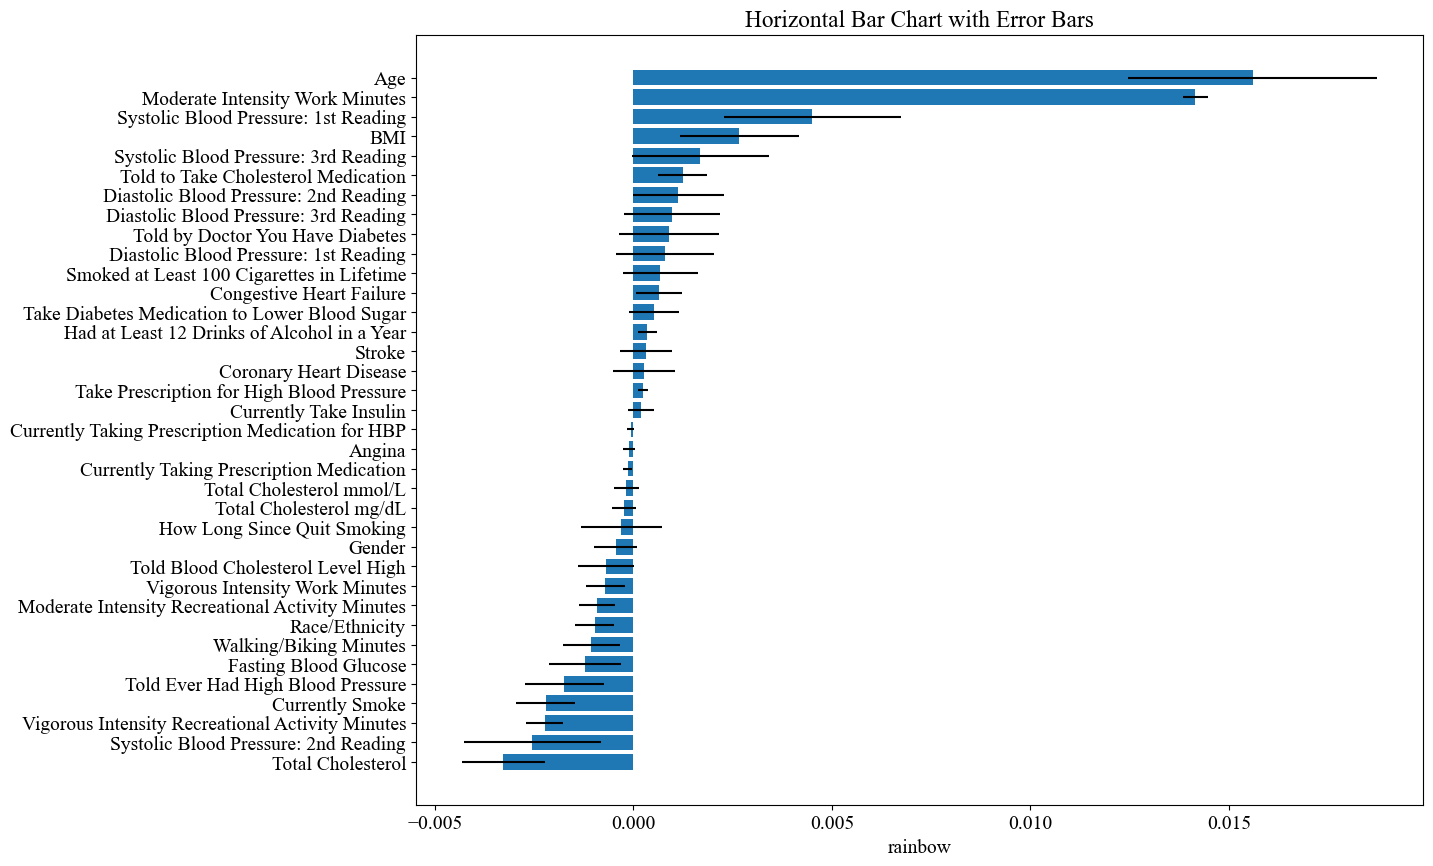

<Figure size 2560x1920 with 0 Axes>

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

importance1 = importance.sort_values('importances_mean')

# norm = mcolors.Normalize(vmin=np.min(importance1['importances_mean']), vmax=np.max(importance1['importances_mean']))
# cmap = plt.cm.get_cmap('viridis')
# normalize = plt.Normalize(vmin=min(importance1['importances_mean']), vmax=max(importance1['importances_mean']))
# colors = cmap(normalize(importance1['importances_mean']))
# 创建条形图
plt.figure(figsize=(13,10))
plt.barh(col, importance1['importances_mean'], xerr=importance1['importances_std'], capsize=0)

plt.xlabel('rainbow')
plt.title('Horizontal Bar Chart with Error Bars')
plt.figure(dpi=400)
plt.show()

# AUC IBS C-Index

In [281]:
def cal_rsf_auc(df):
    E = df.iloc[:,36]
    T = df.iloc[:,37]
    SurvObj = np.array([(e, t) for e, t in zip(E, T)], dtype=[('E', np.bool_), ('T', np.float64)])
    X_train, X_test, y_train, y_test = train_test_split(df, SurvObj, test_size=0.3, random_state=10)
    times = max(X_test['PERMTH_INT（月份）'])-1
    X_train = X_train.iloc[:,:-2]
    X_test = X_test.iloc[:,:-2]
    
    rsf = RandomSurvivalForest(n_estimators=200,random_state=24, n_jobs=-1)
    rsf.fit(X_train, y_train)
    pred = rsf.predict(X_test)
    
    # AUC
    auc = cumulative_dynamic_auc(y_train,y_test, pred, times=12)
    # C-index
    c_index = concordance_index_censored(y_test["E"], y_test["T"], pred)
    
    # iBS
    def calculate_BS(actual, predicted):
        return (predicted - actual)**2
    survival_predictions = rsf.predict_survival_function(X_test)
    # time_points = survival_predictions[0][0].x[0]
    
    
    survival_probs = [s.x for s in survival_predictions]
    #fpr, tpr, thresholds = roc_curve(y_test["E"], survival_probs)
    actual_survival = np.exp(-y_test['T'] / y_test['T'].mean())
    sur_pred_list = []
    for i in range(len(survival_predictions)):
          sur_pred_list.append(survival_predictions[i].y[-1])
    ibs = calculate_BS(actual_survival, sur_pred_list)
    
    print("ibs:",ibs.mean())
    print("C-index:", c_index)
    print("AUC:", auc)
    
    auc_values = []
    c_values = []
    ibs_values = []
    for _ in range(10):
        X_train, X_test, y_train, y_test = train_test_split(df, SurvObj, test_size=0.3)
        # times = max(X_test['PERMTH_INT（月份）'])-1
        X_train = X_train.iloc[:,:-2]
        X_test = X_test.iloc[:,:-2]
        rsf = RandomSurvivalForest(n_jobs=-1,random_state=24, n_estimators=200)
        rsf.fit(X_train, y_train)
        y_pred = rsf.predict(X_test)
        
        auc_boot = cumulative_dynamic_auc(y_train,y_test, y_pred, times=12)
        c_index = concordance_index_censored(y_test["E"], y_test["T"], y_pred)
         
        def calculate_BS(actual, predicted):
             return (predicted - actual)**2
        survival_predictions = rsf.predict_survival_function(X_test)
        sur_pred_list = []
        for i in range(len(survival_predictions)):
            sur_pred_list.append(survival_predictions[i].y[-1])
        actual_survival = np.exp(-y_test['T'] / y_test['T'].mean())
        ibs = calculate_BS(actual_survival, sur_pred_list)
        
        auc_values.append(auc_boot[0])
        c_values.append(c_index[0])
        ibs_values.append(ibs.mean())
        
    auc_values = [x[0] for x in auc_values]
    lower_bound = np.percentile(auc_values, 2.5)
    upper_bound = np.percentile(auc_values, 97.5)
    print("auc95")
    print(f"{lower_bound} --- {upper_bound}")
    
    print("c95")
    lower_bound = np.percentile(c_values, 2.5)
    upper_bound = np.percentile(c_values, 97.5)
    
    print(f"{lower_bound} --- {upper_bound}")
    
    lower_bound = np.percentile(ibs_values, 2.5)
    upper_bound = np.percentile(ibs_values, 97.5)
    print("ibs")
    print(f"{lower_bound} --- {upper_bound}")
    
    return auc_values,c_values,ibs_values

auc_values5,c_values5,ibs_values5 = cal_rsf_auc(none)
auc_values6,c_values6,ibs_values6 = cal_rsf_auc(mild)
auc_values7,c_values7,ibs_values7 = cal_rsf_auc(mode)

ibs: 0.15520710596112078
C-index: (0.7821871505206832, 6259074, 1742904, 105, 59576)
AUC: (array([0.82518767]), 0.8251876699114268)
auc95
0.7776551407655162 --- 0.8389412372405678
c95
0.77639990306795 --- 0.8002757623957066
ibs
0.1481130050175202 --- 0.15379883275395034
ibs: 0.16376523469897364
C-index: (0.751435294277892, 220660, 72983, 25, 1772)
AUC: (array([0.76714913]), 0.7671491303925994)
auc95
0.694455132089639 --- 0.7927027913681347
c95
0.7332693238776975 --- 0.7963064242987906
ibs
0.13910209340839189 --- 0.15637280965986208
ibs: 0.15142807917745824
C-index: (0.7303711729634037, 123349, 45531, 17, 888)
AUC: (array([0.83109485]), 0.8310948533158622)
auc95
0.7403494506904956 --- 0.8523931717259955
c95
0.704727511073575 --- 0.7875009939494629
ibs
0.1417014036874505 --- 0.16389881672496454


In [211]:
print(np.array(auc_values5).mean(),np.array(c_values5).mean(),np.array(ibs_values5).mean())
print(np.array(auc_values6).mean(),np.array(c_values6).mean(),np.array(ibs_values6).mean())
print(np.array(auc_values7).mean(),np.array(c_values7).mean(),np.array(ibs_values7).mean())

0.7813712186550454 0.7853702899035002 0.15045084900672173
0.7643786707513366 0.7553133910392789 0.1503215051463116
0.8078211257987974 0.7499946211968681 0.14920268712717497


In [160]:
import warnings
warnings.filterwarnings('ignore')


In [295]:
def test_a(df):
    train_data, test_data = train_test_split(df, test_size=0.3, random_state=10)
    cox = CoxPHFitter(penalizer=1000)
    cox.fit(train_data, duration_col='PERMTH_INT（月份）', event_col='MORTSTAT(最终死亡状况)')
    predicted_partial_hazards = cox.predict_partial_hazard(test_data)
    E = test_data.iloc[:,36]
    T = test_data.iloc[:,37]
    # times = max(test_data['PERMTH_INT（月份）'])-1
    times = 90
    labels = (T <= times) & E
    auc = roc_auc_score(labels, predicted_partial_hazards.values)
    print(auc)

    # event_at_time = test_data['MORTSTAT(最终死亡状况)']
    # time_at_time = test_data['PERMTH_INT（月份）']
    # c_index = concordance_index(time_at_time, -(predicted_partial_hazards), event_at_time)
    # print(f"C-index: {c_index:.4f}")
    
    # survival_predictions = cox.predict_survival_function(test_data)
    # times = survival_predictions.index.max()
    # times = 12
    # def calculate_BS(actual, predicted):
    #     return (predicted - actual)**2

    # actual_survival = np.exp(-test_data['PERMTH_INT（月份）'] / test_data['PERMTH_INT（月份）'].mean())
    # predicted_survival = survival_predictions.loc[times].mean()
    # ibs = calculate_BS(actual_survival, predicted_survival)
    # print("ibs:",ibs.mean())
    
    # auc_values = []
    # c_values = []
    # ibs_values = []
    # for _ in range(100):
    #     train_data, test_data = train_test_split(df, test_size=0.3)
    #     cox = CoxPHFitter()
    #     cox.fit(train_data, duration_col='PERMTH_INT（月份）', event_col='MORTSTAT(最终死亡状况)')
    #     predicted_partial_hazards = cox.predict_partial_hazard(test_data)
    #     E = test_data.iloc[:,36]
    #     T = test_data.iloc[:,37]
    #     times = max(test_data['PERMTH_INT（月份）'])-1
    #     times = 12
    #     labels = (T <= times) & E
    #     auc = roc_auc_score(labels, predicted_partial_hazards.values)
    #     auc_values.append(auc)
    #     event_at_time = test_data['MORTSTAT(最终死亡状况)']
    #     time_at_time = test_data['PERMTH_INT（月份）']
    #     c_index = concordance_index(time_at_time, -(predicted_partial_hazards), event_at_time)
    #     c_values.append(c_index)
        
    #     survival_predictions = cox.predict_survival_function(test_data)
    #     times = survival_predictions.index.max()
    #     times = 12
    #     def calculate_BS(actual, predicted):
    #         return (predicted - actual)**2

    #     actual_survival = np.exp(-test_data['PERMTH_INT（月份）'] / test_data['PERMTH_INT（月份）'].mean())
    #     predicted_survival = survival_predictions.loc[times].mean()
    #     ibs = calculate_BS(actual_survival, predicted_survival)
    #     ibs_values.append(ibs.mean())
        
    # lower_bound = np.percentile(auc_values, 2.5)
    # upper_bound = np.percentile(auc_values, 97.5)
    # print("auc95")
    # print(f"{lower_bound} --- {upper_bound}")
    
    # lower_bound = np.percentile(c_values, 2.5)
    # upper_bound = np.percentile(c_values, 97.5)
    # print("c95")
    # print(f"{lower_bound} --- {upper_bound}")
    
    # lower_bound = np.percentile(ibs_values, 2.5)
    # upper_bound = np.percentile(ibs_values, 97.5)
    # print("ibs")
    # print(f"{lower_bound} --- {upper_bound}")
    
    # return auc_values,c_values,ibs_values
    return 1,1,1
auc_values,c_values,ibs_values = test_a(none)
auc_values1,c_values1,ibs_values1 = test_a(mild)
auc_values2,c_values2,ibs_values2 = test_a(mode)

0.7708642615818803
0.7370715505664854
0.7389204149839854


In [168]:
print(np.array(auc_values).mean(),np.array(c_values).mean(),np.array(ibs_values).mean())
print(np.array(auc_values1).mean(),np.array(c_values1).mean(),np.array(ibs_values1).mean())
print(np.array(auc_values2).mean(),np.array(c_values2).mean(),np.array(ibs_values2).mean())

0.7568283265302678 0.7930992767694499 0.07223196244773322
0.7457125809394495 0.7739345645444891 0.08512332210078101
0.7177315330510349 0.7478394949475806 0.06975151999937378


# AUC Plot

In [296]:
rsf_none = [0.83535204, 0.79493116, 0.80995588, 0.80949473, 0.80125265,
       0.79925572, 0.79345401, 0.79620025, 0.79522311]
rsf_mild = [0.72645991, 0.78722417, 0.7708214 , 0.77188249, 0.7785595 ,
       0.79459563, 0.76986779, 0.76517285, 0.76578106]
rsf_mode = [0.83109485, 0.82622799, 0.78803966, 0.76152204, 0.75997916,
       0.75539108, 0.74319419, 0.73846261, 0.74467324]
cox_none = [0.7695595764891227, 0.7549602402980186,0.7698532656591488,0.7704647373683611,0.7676171631570238,0.7683337648571656,0.7691100504173898,0.7719727287967666,0.7708642615818803]
cox_mild = [0.7244315148927084,0.7667415803530714,0.7253175830413592,0.7385739222829386,0.7406974731741086,0.7479226124604424,0.7383783378712563,0.7368183644398992,0.7370715505664854]
cox_mode = [0.7959343379194875,0.8044420470891059,0.7544032338504343,0.740493140304698,0.7274878452467156,0.7231617364579331,0.730108543417367,0.7276649144055839,0.7389204149839854]

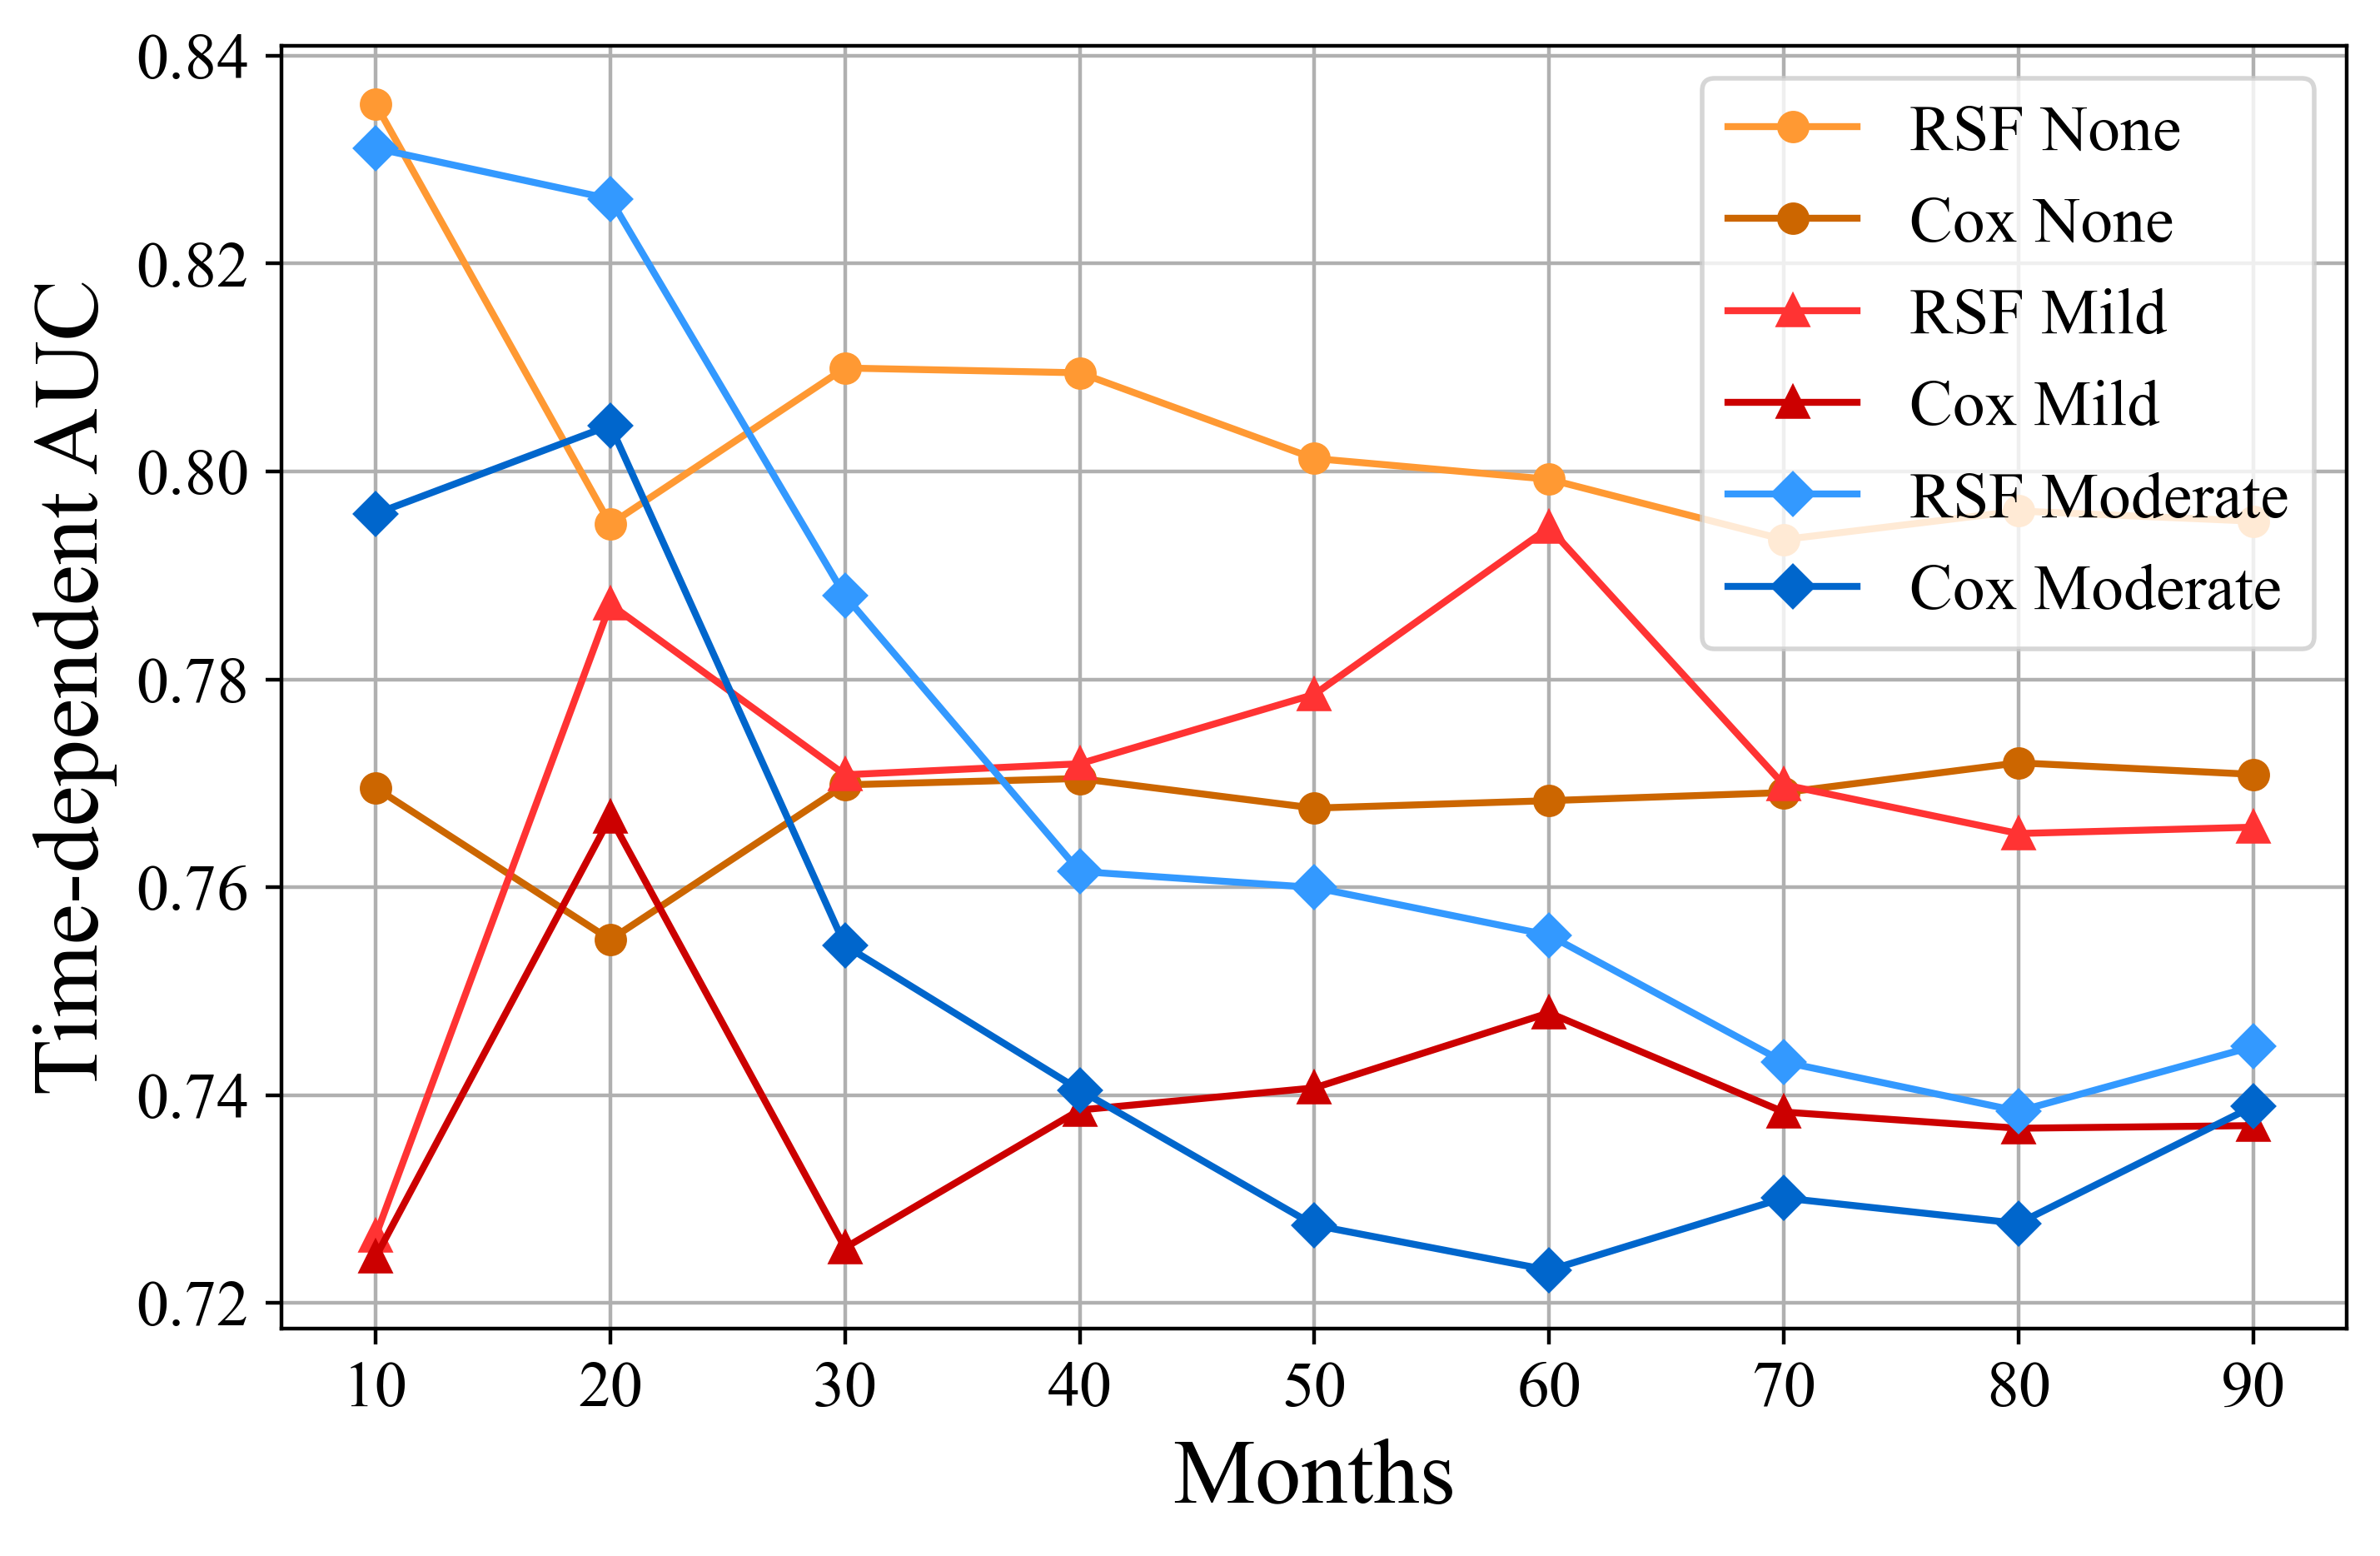

In [298]:
plt.figure(figsize=(8,5),dpi=400)
times = [10, 20, 30, 40, 50, 60, 70, 80, 90]
plt.plot(times, rsf_none, color='#FF9933', label='RSF None', marker='o')
plt.plot(times, cox_none, color='#CC6600', label='Cox None', marker='o')
plt.plot(times, rsf_mild, color='#FF3333', label='RSF Mild', marker='^')
plt.plot(times, cox_mild, color='#CC0000', label='Cox Mild', marker='^')
plt.plot(times, rsf_mode, color='#3399FF', label='RSF Moderate', marker='D')
plt.plot(times, cox_mode, color='#0066CC', label='Cox Moderate', marker='D')
plt.ylabel('Time-dependent AUC', fontsize=20)
plt.xlabel('Months', fontsize=20)
plt.grid(True)
plt.legend(fontsize=14)

In [301]:
# net_benefit_model,net_benefit_all, _,_ = process_data_rsf(none)
net_benefit_model,net_benefit_all, _,_ = process_data_rsf(mild)
net_benefit_model,net_benefit_all, _,_ = process_data_rsf(mode)

[0.9979508196721312, 0.9754098360655737, 0.9508196721311475, 0.9262295081967213, 0.8995901639344263, 0.8831967213114754, 0.8770491803278688, 0.8709016393442623, 0.8688524590163934, 0.8586065573770492, 0.8442622950819673, 0.8381147540983607, 0.8278688524590164, 0.8237704918032787, 0.8217213114754098, 0.8032786885245902, 0.7950819672131147, 0.7868852459016393, 0.7807377049180327, 0.7725409836065574, 0.7684426229508197, 0.7663934426229508, 0.7602459016393442, 0.7479508196721312, 0.7377049180327869, 0.7213114754098361, 0.7110655737704918, 0.694672131147541, 0.6762295081967213, 0.6639344262295082, 0.6475409836065574, 0.639344262295082, 0.6188524590163934, 0.6045081967213115, 0.5799180327868853, 0.5594262295081968, 0.5450819672131147, 0.5348360655737705, 0.5122950819672131, 0.49385245901639346, 0.4774590163934426, 0.45901639344262296, 0.4426229508196721, 0.42418032786885246, 0.3975409836065574, 0.38114754098360654, 0.36885245901639346, 0.3422131147540984, 0.319672131147541, 0.303278688524590

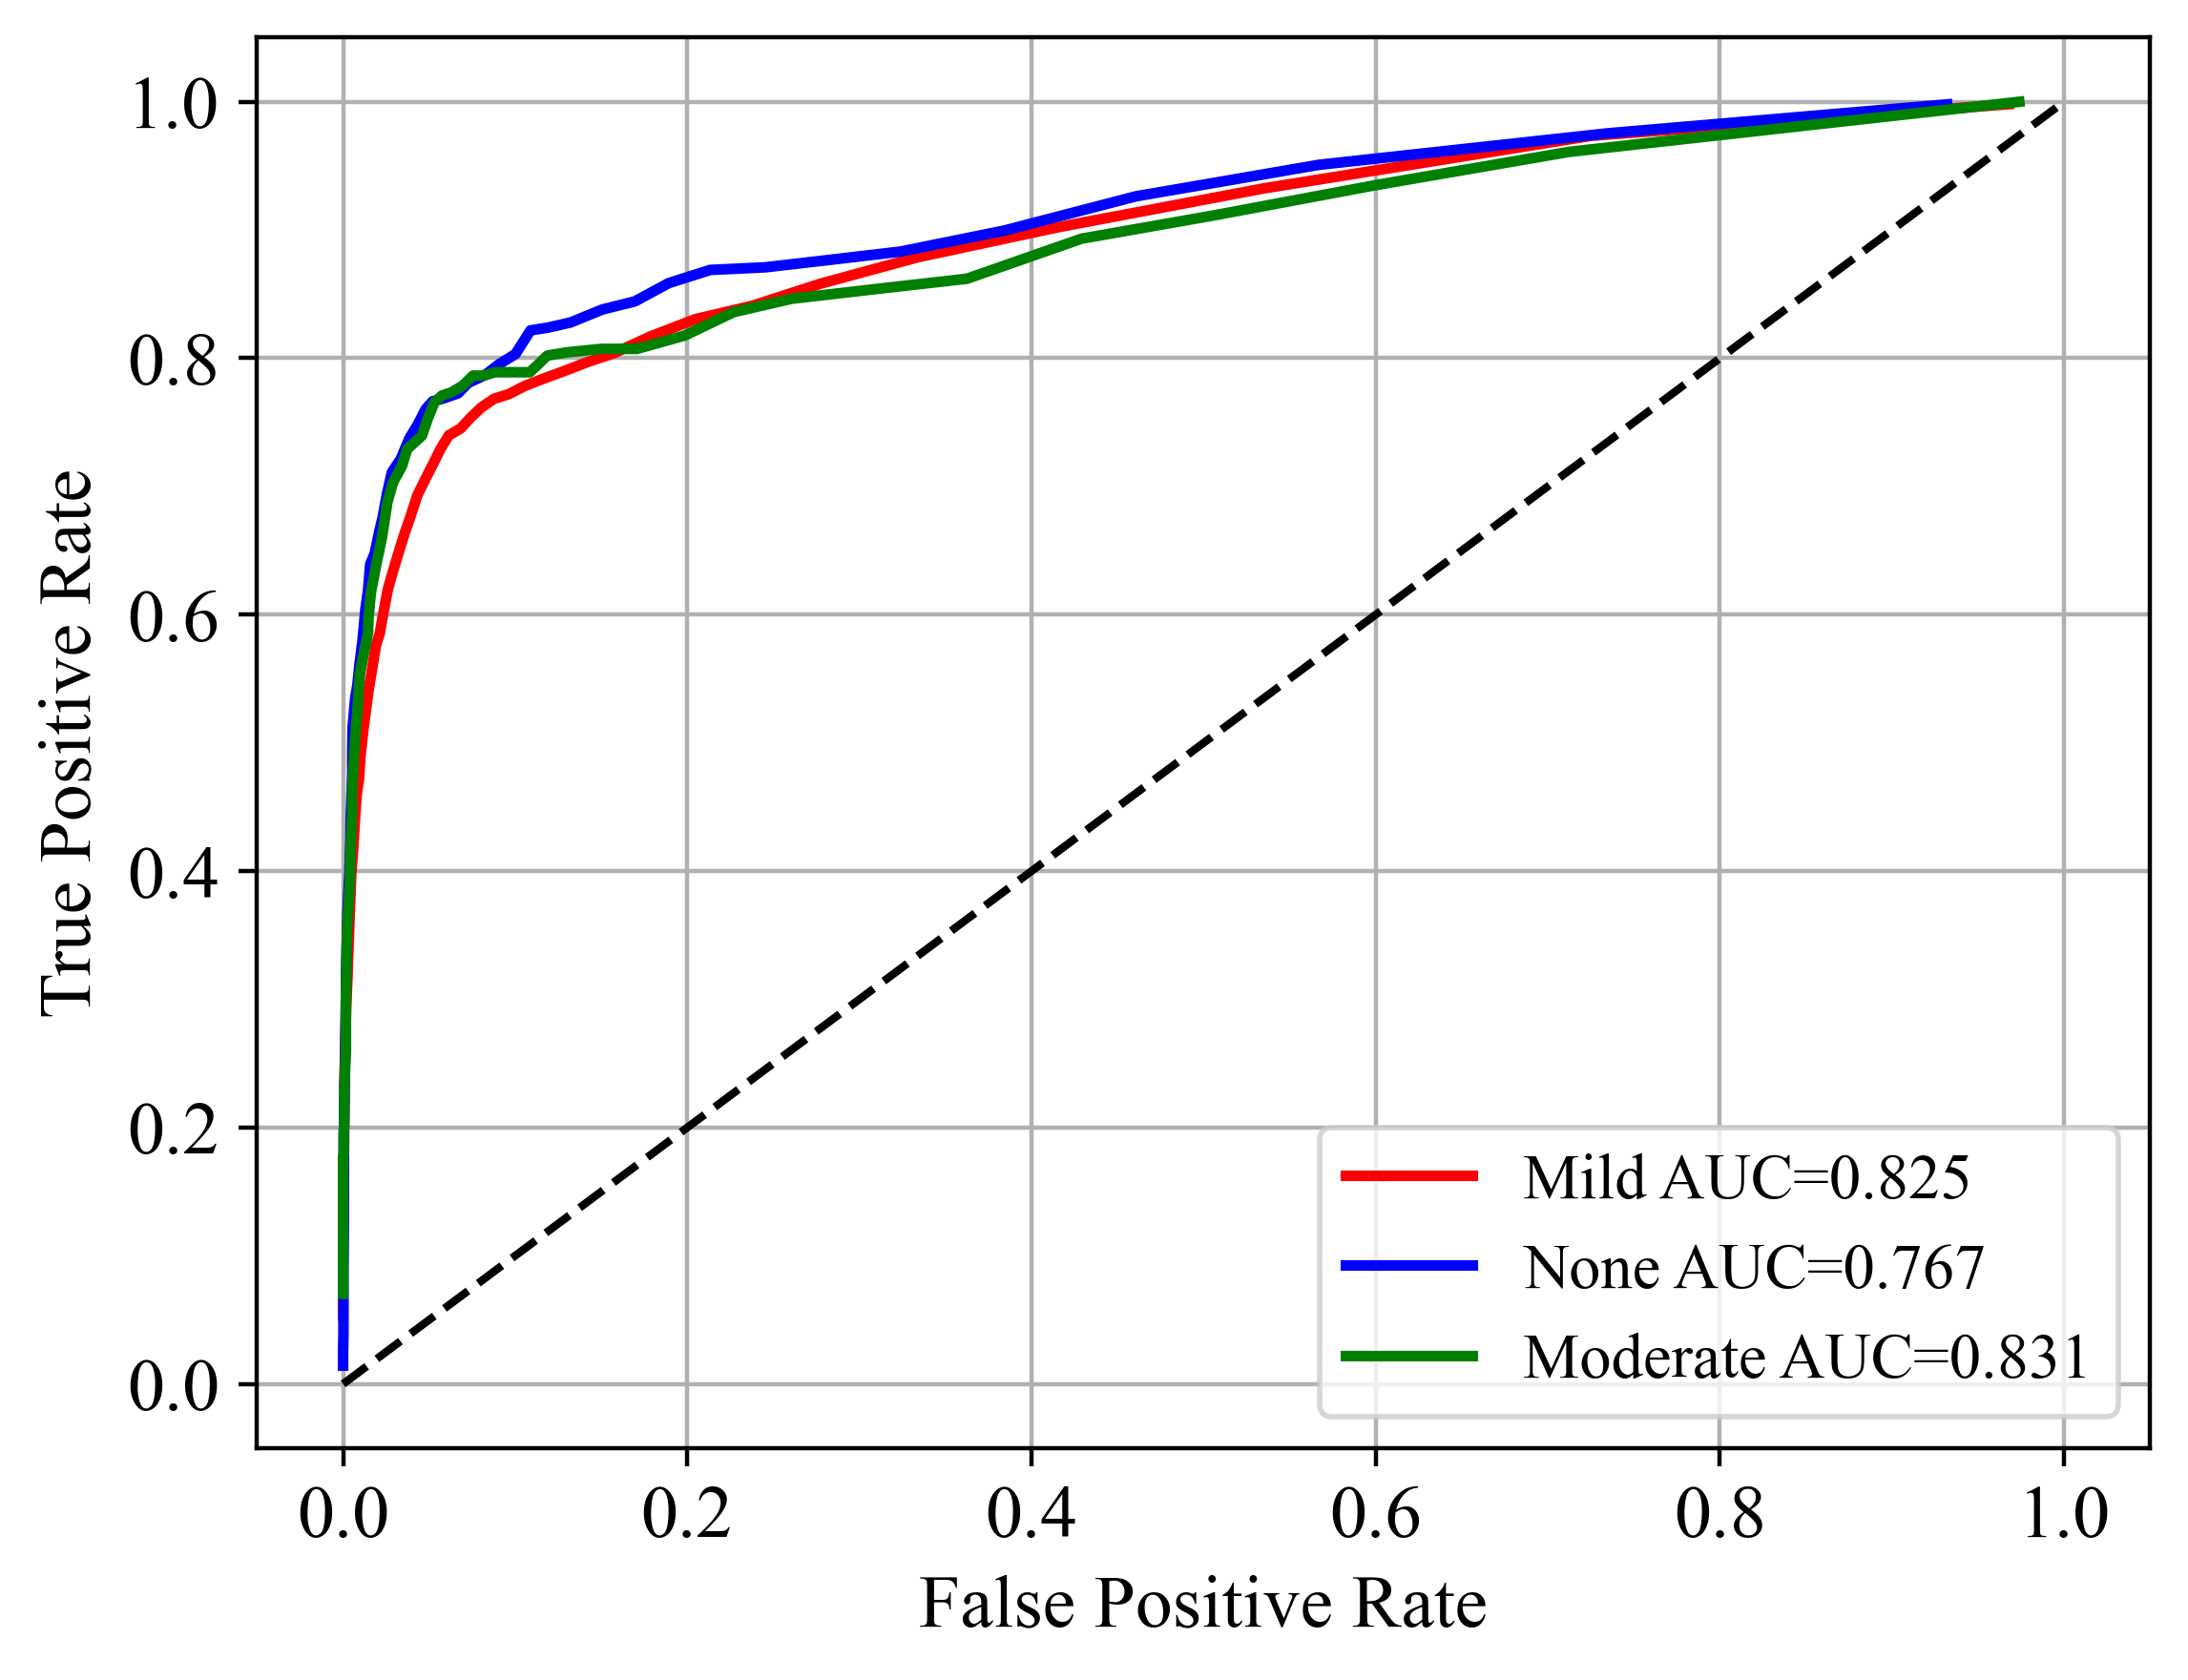

In [304]:
none_tpr = [0.9981039059537353, 0.9734546833522942, 0.9324990519529769, 0.9021615472127418, 0.8786499810390596, 0.8581721653394009, 0.8407281001137656, 0.8304891922639362, 0.8172165339400834, 0.8039438756162306, 0.7971179370496777, 0.7895335608646189, 0.7834660599165718, 0.7781569965870307, 0.7720894956389837, 0.7682973075464543, 0.7614713689799014, 0.7535077739855897, 0.745164960182025, 0.7398558968524839, 0.7296169890026545, 0.7182404247250663, 0.7064846416382252, 0.6928327645051194, 0.6765263557072431, 0.664012135001896, 0.645430413348502, 0.6317785362153963, 0.6200227531285551, 0.6006825938566553, 0.5851346226772848, 0.5756541524459613, 0.558968524838832, 0.5411452408039439, 0.5259764884338263, 0.5115661736822147, 0.502464922260144, 0.4888130451270383, 0.4713689799014031, 0.4603716344330679, 0.4433067880166856, 0.42813803564656805, 0.4114524080394388, 0.3970420932878271, 0.3807356844899507, 0.36177474402730375, 0.34584755403868034, 0.3280242700037922, 0.31778536215396286, 0.3056503602578688, 0.2912400455062571, 0.27569207432688664, 0.2578687902919985, 0.24232081911262798, 0.22639362912400454, 0.21084565794463406, 0.20136518771331058, 0.18885096700796358, 0.17292377701934017, 0.15889268107698143, 0.14751611679939325, 0.1353811149032992, 0.12514220705346984, 0.11224876753886993, 0.09632157755024649, 0.08418657565415244, 0.07508532423208192, 0.06598407281001138, 0.05953735305271141, 0.053469852104664393]
none_fpr = [0.9677609520651413, 0.7251390884639475, 0.5352050403448657, 0.41549684978445894, 0.3336649349692347, 0.27755056924947497, 0.23727939280056004, 0.20470874322979993, 0.17902803876054676, 0.15743708780074425, 0.1422939464279135, 0.12755609594340667, 0.11528683541505472, 0.10519140783316754, 0.09653292067351976, 0.08761652113039313, 0.08021075126192845, 0.07398400943222432, 0.06827309236947791, 0.061419991894182235, 0.05677756899156258, 0.05254043697726687, 0.04808223720570355, 0.043071368040971225, 0.03916583766257691, 0.035886665929774145, 0.031575844663055894, 0.028554585313731992, 0.02604915073136583, 0.023322648391732065, 0.021259349323901108, 0.019011827125013817, 0.017022217309605393, 0.014811539736929369, 0.013337754688478686, 0.01190081426623927, 0.011163921742013928, 0.010058582955675915, 0.009211156552816771, 0.007958439261633692, 0.007037323606352014, 0.006374120334549206, 0.00556353855790133, 0.004752956781253454, 0.004273976640506982, 0.0037213072473379757, 0.003316016359014038, 0.0028001915920562986, 0.002579123834788696, 0.0021738329464647582, 0.0017685420581408202, 0.0014369404222394164, 0.001215872664971814, 0.0008842710290704101, 0.0008105817766478759, 0.0007368925242253417, 0.0006632032718028076, 0.0005895140193802734, 0.00044213551453520505, 0.0003316016359014038, 0.0002579123834788696, 0.00011053387863380126, 7.368925242253417e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mild_tpr = [0.9979508196721312, 0.9754098360655737, 0.9508196721311475, 0.9262295081967213, 0.8995901639344263, 0.8831967213114754, 0.8770491803278688, 0.8709016393442623, 0.8688524590163934, 0.8586065573770492, 0.8442622950819673, 0.8381147540983607, 0.8278688524590164, 0.8237704918032787, 0.8217213114754098, 0.8032786885245902, 0.7950819672131147, 0.7868852459016393, 0.7807377049180327, 0.7725409836065574, 0.7684426229508197, 0.7663934426229508, 0.7602459016393442, 0.7479508196721312, 0.7377049180327869, 0.7213114754098361, 0.7110655737704918, 0.694672131147541, 0.6762295081967213, 0.6639344262295082, 0.6475409836065574, 0.639344262295082, 0.6188524590163934, 0.6045081967213115, 0.5799180327868853, 0.5594262295081968, 0.5450819672131147, 0.5348360655737705, 0.5122950819672131, 0.49385245901639346, 0.4774590163934426, 0.45901639344262296, 0.4426229508196721, 0.42418032786885246, 0.3975409836065574, 0.38114754098360654, 0.36885245901639346, 0.3422131147540984, 0.319672131147541, 0.30327868852459017, 0.2889344262295082, 0.26434426229508196, 0.2459016393442623, 0.23155737704918034, 0.22540983606557377, 0.19262295081967212, 0.18237704918032788, 0.16598360655737704, 0.14549180327868852, 0.125, 0.08811475409836066, 0.06557377049180328, 0.04918032786885246, 0.0389344262295082, 0.02459016393442623, 0.022540983606557378, 0.018442622950819672, 0.014344262295081968, 0.014344262295081968, 0.014344262295081968]
mild_fpr = [0.9320119352088662, 0.7348678601875532, 0.56692242114237, 0.4605711849957374, 0.3842710997442455, 0.32395566922421143, 0.28495311167945436, 0.24531116794543906, 0.21334185848252343, 0.18925831202046037, 0.1694373401534527, 0.15089514066496162, 0.13213981244671782, 0.11871270247229326, 0.10890878090366582, 0.10017050298380221, 0.09036658141517477, 0.08248081841432225, 0.0726768968456948, 0.06670929241261722, 0.05775788576300085, 0.05200341005967604, 0.0479539641943734, 0.043265132139812444, 0.038576300085251494, 0.03346121057118499, 0.0283461210571185, 0.02557544757033248, 0.023017902813299233, 0.020886615515771527, 0.018329070758738276, 0.01577152600170503, 0.014492753623188406, 0.01300085251491901, 0.011295822676896846, 0.00937766410912191, 0.008312020460358057, 0.007033248081841432, 0.005541346973572037, 0.005328218243819267, 0.005328218243819267, 0.004901960784313725, 0.004475703324808184, 0.004262574595055414, 0.0036231884057971015, 0.0029838022165387893, 0.0025575447570332483, 0.002131287297527707, 0.0017050298380221654, 0.0017050298380221654, 0.0014919011082693947, 0.0012787723785166241, 0.0010656436487638534, 0.0008525149190110827, 0.0008525149190110827, 0.00042625745950554135, 0.00042625745950554135, 0.00042625745950554135, 0.00042625745950554135, 0.00042625745950554135, 0.00021312872975277067, 0.00021312872975277067, 0.00021312872975277067, 0.00021312872975277067, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mode_tpr = [1.0, 0.9817708333333334, 0.9609375, 0.9348958333333334, 0.9114583333333334, 0.8932291666666666, 0.8619791666666666, 0.8541666666666666, 0.8463541666666666, 0.8359375, 0.8177083333333334, 0.8072916666666666, 0.8072916666666666, 0.8046875, 0.8020833333333334, 0.7890625, 0.7890625, 0.7890625, 0.7864583333333334, 0.7864583333333334, 0.7786458333333334, 0.7734375, 0.7708333333333334, 0.765625, 0.7526041666666666, 0.7395833333333334, 0.734375, 0.7291666666666666, 0.7161458333333334, 0.703125, 0.6875, 0.6614583333333334, 0.6380208333333334, 0.6171875, 0.5989583333333334, 0.5859375, 0.5729166666666666, 0.5546875, 0.5442708333333334, 0.5234375, 0.5026041666666666, 0.4791666666666667, 0.4635416666666667, 0.4453125, 0.4166666666666667, 0.3932291666666667, 0.3697916666666667, 0.3541666666666667, 0.3307291666666667, 0.2994791666666667, 0.2838541666666667, 0.28125, 0.2682291666666667, 0.2604166666666667, 0.23958333333333334, 0.22135416666666666, 0.203125, 0.1953125, 0.1796875, 0.17708333333333334, 0.17447916666666666, 0.16145833333333334, 0.14583333333333334, 0.12239583333333333, 0.11979166666666667, 0.10677083333333333, 0.0859375, 0.08072916666666667, 0.07552083333333333, 0.0703125]
mode_fpr = [0.9739445910290238, 0.8519129287598944, 0.712401055408971, 0.5996042216358839, 0.5062664907651715, 0.42908970976253297, 0.362467018469657, 0.31101583113456466, 0.2605540897097625, 0.22691292875989447, 0.19854881266490765, 0.170844327176781, 0.150065963060686, 0.13060686015831136, 0.11873350923482849, 0.10850923482849605, 0.09630606860158311, 0.08806068601583114, 0.08212401055408972, 0.07552770448548812, 0.0695910290237467, 0.06299472295514512, 0.05738786279683377, 0.05310026385224274, 0.04914248021108179, 0.045844327176781004, 0.04155672823218998, 0.03726912928759894, 0.03430079155672823, 0.029023746701846966, 0.025725593667546173, 0.022757255936675463, 0.01912928759894459, 0.016160949868073878, 0.014841688654353561, 0.014511873350923483, 0.012532981530343008, 0.009894459102902375, 0.009234828496042216, 0.008245382585751979, 0.006926121372031662, 0.005936675461741424, 0.005277044854881266, 0.005277044854881266, 0.004287598944591029, 0.00395778364116095, 0.002968337730870712, 0.002308707124010554, 0.001978891820580475, 0.0016490765171503958, 0.0016490765171503958, 0.0016490765171503958, 0.0016490765171503958, 0.0016490765171503958, 0.0009894459102902375, 0.0006596306068601583, 0.0006596306068601583, 0.00032981530343007914, 0.00032981530343007914, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
plt.figure(dpi=400)
lw = 2
plt.plot(none_fpr, none_tpr, color='red', lw=lw, label=f"Mild AUC=0.825")
plt.plot(mild_fpr, mild_tpr, color='blue', lw=lw, label=f"None AUC=0.767")
plt.plot(mode_fpr, mode_tpr, color='green', lw=lw, label=f"Moderate AUC=0.831")
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)

# Stat

In [212]:
none.columns

Index(['BPQ020（曾经告诉过你有高血压）', 'BPQ040A（服用高血压处方）', 'BPQ050A（现在正在服用治疗HBP的处方药）',
       'BPQ080（曾经被告知的血液胆固醇水平很高）', 'BPQ090D（被告知服用胆固醇处方药）', 'BPQ100D（现在正在服用处方药）',
       'SMQ020（一生中至少抽过 100 支烟？）', 'SMQ040（现在抽烟吗？）', 'SMQ050Q（戒烟多久了？）',
       'LBXGLU（空腹血糖mg/dL)', 'DIQ010（医生告诉你有糖尿病）', 'DIQ050（现在服用胰岛素）',
       'DIQ070（服用糖尿病药来降低血糖）', 'BMXBMI（BMI）', 'PAD615（高强度工作分钟）',
       'PAD630（中等强度工作分钟）', 'PAD645（步行/自行车分钟）', 'PAD660（剧烈娱乐活动分钟）',
       'PAD675（中等娱乐活动分钟）', 'BPXSY1（收缩压：血压第 1 次）', 'BPXDI1（舒张压：血压第 1 次）',
       'BPXSY2（收缩压：血压第 2 次）', 'BPXDI2（舒张压：血压第 2次）', 'BPXSY3（收缩压：血压第 3次）',
       'BPXDI3（舒张压：血压第 3 次）', 'RIAGENDR（性别）', 'RIDAGEYR（年龄）', 'RIDRETH1（种族）',
       'MCQ160B（充血性心力衰竭）', 'MCQ160C（冠心病）', 'MCQ160D（心绞痛）', 'MCQ160F（中风）',
       'LBXTC', 'LBDTCSI', 'LBDTCSI(总胆固醇mmol/L）', 'ALQ101（每 1 年至少喝过 12 杯酒）',
       'MORTSTAT(最终死亡状况)', 'PERMTH_INT（月份）'],
      dtype='object')

In [279]:
mode['MCQ160F（中风）'].value_counts() / len(mode) * 100

MCQ160F（中风）
2    91.661545
1     7.887728
9     0.450727
Name: count, dtype: float64

In [243]:
print(f"{none['PAD675（中等娱乐活动分钟）'].mean():.1f}±{none['PAD675（中等娱乐活动分钟）'].std():.2f}")

62.9±62.03


In [219]:
none['RIDRETH1（种族）'].value_counts() / len(none)

RIDRETH1（种族）
3    0.383724
4    0.227592
1    0.153052
5    0.135117
2    0.100515
Name: count, dtype: float64

In [189]:
length = len(none[none['RIDAGEYR（年龄）'] > 65])
print(length)
length / len(none)

9138


0.2148045415011401